# Imports

In [66]:
import sys
import numpy as np
import multiprocessing as mp
import ipyparallel as ipp

from random import uniform
from math import sqrt
from time import time, sleep
from matplotlib import pyplot as plt
from functools import partial
from ipyparallel import Client
from ipyparallel.util import interactive

# Print output to terminal rather than notebook
sys.stdout = open('/dev/stdout', 'w')

%matplotlib notebook

# Functions and Classes

### Serial Implimentation

In [26]:
def darts_serial(num_darts, repititions):
    '''
    Serial implimentation of darts algorithm. Takes as argument an integer
    representing the number of darts to be thrown and an integer representing
    the number of times to run the simulation. Returns a list of two tuples.
    The first contains the mean execution time and std. The second contains the
    mean simulation rate (darts/second) and std.
    '''

    # Define the total number of darts we'll throw.
    number_of_darts = num_darts

    # Define some lists to save statistical information about sim.
    pi_approximations = []
    execution_times = []
    simulation_rates = []

    for _ in range(repititions):
        # Define a variable to store the number of darts that fall inside the
        # circle.
        number_of_darts_in_circle = 0

        # We will use time() to record the execution time of the loop that runs
        # then dart throwing simulation.
        start_time = time()

        # This loop simulates the dart throwing. For each dart, find a random
        # position in the unit square for it to fall. Test if it falls within
        # the circle by calculating the distance from the origin (0.5, 0.5) to
        # the dart. Darts that fall within 0.5 of the origin are within the
        # circle.
        for n in range(number_of_darts):
            x, y = uniform(0, 1), uniform(0, 1)
            if sqrt((x - 0.5)**2 + (y - 0.5)**2) <= 0.5:
                number_of_darts_in_circle += 1

        # Record the time after the conclusion of the loop.
        end_time = time()
        # The total time required to run the loop is the difference.
        execution_time = end_time - start_time

        # We can calculate an approximate numerical value for pi using the
        # formula for the area of a circle (which defines pi). A = pi * r**2.
        # Here, r=0.5 and the area of the circle can be approximated by the
        # ratio of the number of darts that fall inside the circle over the
        # total number of darts thrown. Thus we have pi = 4 * Area.
        pi_approx = 4 * number_of_darts_in_circle / float(number_of_darts)

        pi_approximations.append(pi_approx)
        execution_times.append(execution_time)
        simulation_rates.append(number_of_darts / execution_time)

    print(f"Pi Approximation: {np.mean(pi_approximations)}"
          f" for {number_of_darts} number of darts.")

    mean_execution_time = np.mean(execution_times)
    std_execution_time = np.std(execution_times)
    mean_simulation_rate = np.mean(simulation_rates)
    std_simulation_rate = np.std(simulation_rates)

    return [(mean_execution_time, std_execution_time),
            (mean_simulation_rate, std_simulation_rate)]

### Multiprocessing Implimentation

In [70]:
# I'll pull this code out of the main function to make implimenting 
# multiprocessing and ipcluster cleaner.

def dart_throw(number_of_darts):
    '''
    This loop simulates the dart throwing. For each dart, find a random
    position in the unit square for it to fall. Test if it falls within
    the circle by calculating the distance from the origin (0.5, 0.5) to
    the dart. Darts that fall within 0.5 of the origin are within the
    circle.
    '''
    # Define a variable to store the number of darts that fall inside the
    # circle.
    number_of_darts_in_circle = 0
    
    for n in range(number_of_darts):
        x, y = uniform(0, 1), uniform(0, 1)
        if sqrt((x - 0.5)**2 + (y - 0.5)**2) <= 0.5:
            number_of_darts_in_circle += 1
    
    return number_of_darts_in_circle

In [28]:
def darts_multiprocessing(num_darts, repititions):
    '''
    Multiprocessing implimentation of darts algorithm. Takes as argument an 
    integer representing the number of darts to be thrown and an integer 
    representing the number of times to run the simulation. Returns a list of 
    two tuples. The first contains the mean execution time and std. The second 
    contains the mean simulation rate (darts/second) and std.
    '''

    # Define the total number of darts we'll throw.
    number_of_darts = num_darts

    # Define some lists to save statistical information about sim.
    pi_approximations = []
    execution_times = []
    simulation_rates = []

    for _ in range(repititions):
        # We will use time() to record the execution time of the loop that runs
        # then dart throwing simulation.
        start_time = time()

        try:
            pool = mp.Pool(4)  # Number of processes
            # Break the task into four pieces and use mp.Pool
            # to execute concurrently over 4 processes.
            count = pool.map(dart_throw, [number_of_darts//4] * 4)
        finally:  # To make sure processes are closed in the end
            pool.close()
            pool.join()

        # Record the time after the conclusion of the loop.
        end_time = time()
        # The total time required to run the loop is the difference.
        execution_time = end_time - start_time

        # We can calculate an approximate numerical value for pi using the
        # formula for the area of a circle (which defines pi). A = pi * r**2.
        # Here, r=0.5 and the area of the circle can be approximated by the
        # ratio of the number of darts that fall inside the circle over the
        # total number of darts thrown. Thus we have pi = 4 * Area.
        pi_approx = 4 * sum(count) / float(number_of_darts)

        pi_approximations.append(pi_approx)
        execution_times.append(execution_time)
        simulation_rates.append(number_of_darts / execution_time)

    print(f"Pi Approximation: {np.mean(pi_approximations)}"
          f" for {number_of_darts} number of darts.")

    mean_execution_time = np.mean(execution_times)
    std_execution_time = np.std(execution_times)
    mean_simulation_rate = np.mean(simulation_rates)
    std_simulation_rate = np.std(simulation_rates)

    return [(mean_execution_time, std_execution_time),
            (mean_simulation_rate, std_simulation_rate)]

### Ipyparallel Implimentation

In [75]:
# Setup ipcluster
rc = Client()
rc.block = True
view = rc.load_balanced_view()

# I need to import modules this way to be available in ipcluster namespace.
# To clean this up, I think in principle I could just import them this way
# to begin with.
dview = rc[:]
with dview.sync_imports():
    from random import uniform
    from math import sqrt
    from time import time

def darts_ipcluster(num_darts, repititions):
    '''
    Ipyparallel implimentation of darts algorithm. Takes as argument an 
    integer representing the number of darts to be thrown and an integer 
    representing the number of times to run the simulation. Returns a list of 
    two tuples. The first contains the mean execution time and std. The second 
    contains the mean simulation rate (darts/second) and std.
    '''
    
    # Define the total number of darts we'll throw.
    number_of_darts = num_darts

    # Define some lists to save statistical information about sim.
    pi_approximations = []
    execution_times = []
    simulation_rates = []

    for _ in range(repititions):
        # We will use time() to record the execution time of the loop that runs
        # then dart throwing simulation.
        start_time = time()

        # Same as in mp implimentation, break number_of_darts into 4 equal
        # lenth pieces to run (ideally) on the 4 cores available
        count = list(view.map(dart_throw, [number_of_darts//4] * 4))

        # Record the time after the conclusion of the loop.
        end_time = time()
        # The total time required to run the loop is the difference.
        execution_time = end_time - start_time

        # We can calculate an approximate numerical value for pi using the
        # formula for the area of a circle (which defines pi). A = pi * r**2.
        # Here, r=0.5 and the area of the circle can be approximated by the
        # ratio of the number of darts that fall inside the circle over the
        # total number of darts thrown. Thus we have pi = 4 * Area.
        pi_approx = 4 * sum(count) / float(number_of_darts)

        pi_approximations.append(pi_approx)
        execution_times.append(execution_time)
        simulation_rates.append(number_of_darts / execution_time)

    print(f"Pi Approximation: {np.mean(pi_approximations)}"
          f" for {number_of_darts} number of darts.")

    mean_execution_time = np.mean(execution_times)
    std_execution_time = np.std(execution_times)
    mean_simulation_rate = np.mean(simulation_rates)
    std_simulation_rate = np.std(simulation_rates)

    return [(mean_execution_time, std_execution_time),
            (mean_simulation_rate, std_simulation_rate)]

# Run the Algorithms

### Run the serial alg.

In [29]:
# Generate evenly spaced list of integers of length 100 from 10^1 to 10^7.
x = np.logspace(1, 7, num=100, dtype=int)

# Empty lists to store results for plotting
exe_times = []  # mean execution times; serial alg.
exe_errors = []  # std of execution times; serial alg.
sim_rates = []  # simulation rates; serial alg

# Generate the simulation and store results in list for plotting.
for n in x:
    result = darts_serial(n, 50)
    exe_times.append(result[0][0])
    exe_errors.append(result[0][1])
    sim_rates.append(result[1][0])

** Here I'll plot the data for the serial simulation and also save it to analysis_plot_serial.png**

<IPython.core.display.Javascript object>


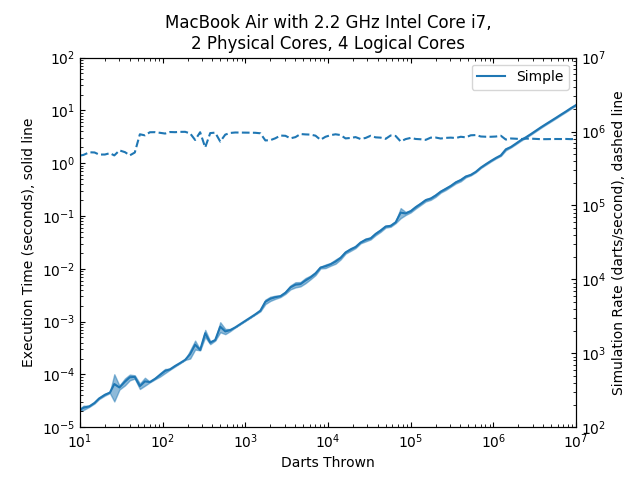

In [82]:
# Convert these lists to np arrays to make them easier to work with
exe_times_array = np.array(exe_times)
exe_errors_array = np.array(exe_errors)

fig, ax1 = plt.subplots()

# Change the background opacity, which defaults to transparent.
fig.patch.set_alpha(1)

# Plot execution times.
ax1.loglog(x, exe_times, color="C0", label="Simple")

# Plot std's as highlighted regions.
ax1.fill_between(x, exe_times_array - exe_errors_array / 2, 
                 exe_times_array + exe_errors_array / 2,
                 alpha=0.5, edgecolor="C0", facecolor="C0")

# Plot simulation rates.
ax2 = ax1.twinx()
ax2.loglog(x, sim_rates, linestyle="--")

# Set reasonable x/y limits.
plt.xlim(10, 10**7)
ax1.set_ylim(10**-5, 10**2)
ax2.set_ylim(10**2, 10**7)

# Set labels/title for plot
ax1.set_ylabel("Execution Time (seconds), solid line")
ax1.set_xlabel("Darts Thrown")
ax2.set_ylabel("Simulation Rate (darts/second), dashed line")
plt.title("MacBook Air with 2.2 GHz Intel Core i7,\n2 Physical Cores, "
          "4 Logical Cores")

# Show the legend in the location that mpl deems best.
ax1.legend(loc="best")

# Turn on plt ticks on the top of the plot and have them pointing in to plot.
ax1.tick_params(which="both", top="on", direction="in")
ax2.tick_params(which="both", direction="in")

# Save Plot
plt.savefig("analysis_plot_serial.png")

plt.show()

### Run the multiprocessing algorithm

In [38]:
# Generate evenly spaced list of integers of length 100 from 10^1 to 10^7.
x_mp = np.logspace(1, 7, num=100, dtype=int)

# Empty lists to store results for plotting
exe_times_mp = []  # mean execution times; multiprocessing alg.
exe_errors_mp = []  # std of execution times; multiprocessing alg.
sim_rates_mp = []  # simulation rates; multiprocessing alg.

# Generate the simulation and store results in list for plotting.
for n in x_mp:
    # I'm running out of time so I'll only run this simulation 10 times
    # for each n, instead of 50 as was done for the serial case
    result_mp = darts_multiprocessing(n, 10)
    exe_times_mp.append(result_mp[0][0])
    exe_errors_mp.append(result_mp[0][1])
    sim_rates_mp.append(result_mp[1][0])

** Add the multiprocessing data to the plot and save as analysis_plot_mp.png. **

<IPython.core.display.Javascript object>


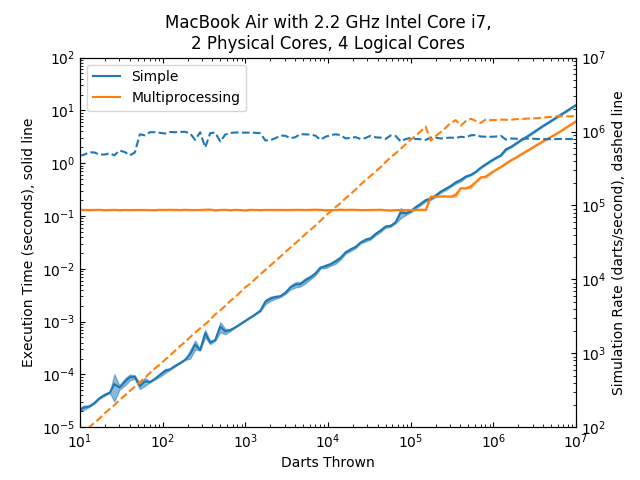

In [81]:
# Convert these lists to np arrays to make them easier to work with
exe_times_mp_array = np.array(exe_times_mp)
exe_errors_mp_array = np.array(exe_errors_mp)

fig, ax1 = plt.subplots()

# Change the background opacity, which defaults to transparent.
fig.patch.set_alpha(1)

# Plot execution times.
ax1.loglog(x, exe_times, color="C0", label="Simple")
ax1.loglog(x_mp, exe_times_mp, color="C1", label="Multiprocessing")

# Plot std's as highlighted regions.
ax1.fill_between(x, exe_times_array - exe_errors_array / 2, 
                 exe_times_array + exe_errors_array / 2,
                 alpha=0.5, edgecolor="C0", facecolor="C0")
ax1.fill_between(x_mp, exe_times_mp_array - exe_errors_mp_array / 2, 
                 exe_times_mp_array + exe_errors_mp_array / 2,
                 alpha=0.5, edgecolor="C1", facecolor="C1")

# Plot simulation rates.
ax2 = ax1.twinx()
ax2.loglog(x, sim_rates, linestyle="--")
ax2.loglog(x_mp, sim_rates_mp, linestyle="--")

# Set reasonable x/y limits.
plt.xlim(10, 10**7)
ax1.set_ylim(10**-5, 10**2)
ax2.set_ylim(10**2, 10**7)

# Set labels/title for plot
ax1.set_ylabel("Execution Time (seconds), solid line")
ax1.set_xlabel("Darts Thrown")
ax2.set_ylabel("Simulation Rate (darts/second), dashed line")
plt.title("MacBook Air with 2.2 GHz Intel Core i7,\n2 Physical Cores, "
          "4 Logical Cores")

# Show the legend in the location that mpl deems best.
ax1.legend(loc="best")

# Turn on plt ticks on the top of the plot and have them pointing in to plot.
ax1.tick_params(which="both", top="on", direction="in")
ax2.tick_params(which="both", direction="in")

# Save Plot
plt.savefig("analysis_plot_mp.png")

plt.show()

### Run the ipyparallel implimentation

**Note: to begin with I need to start the IPython controller and the four IPython engines that I'm using, which I do with the command: ** 

                                    ```$ ipcluster start -n 4```
                                   

In [78]:
# Generate evenly spaced list of integers of length 100 from 10^1 to 10^7.
x_ipc = np.logspace(1, 7, num=100, dtype=int)

# Empty lists to store results for plotting
exe_times_ipc = []  # mean execution times; ipcluster alg.
exe_errors_ipc = []  # std of execution times; ipcluster alg.
sim_rates_ipc = []  # simulation rates; ipcluster alg.

# Generate the simulation and store results in list for plotting.
for n in x_ipc:
    # I run each simulation 50 times for statitistics, same as for the serial
    # implimentation.
    result_ipc = darts_ipcluster(n, 50)
    exe_times_ipc.append(result_ipc[0][0])
    exe_errors_ipc.append(result_ipc[0][1])
    sim_rates_ipc.append(result_ipc[1][0])

** Add the ipcluster data to the plot and save as analysis_plot_all.png. **

<IPython.core.display.Javascript object>


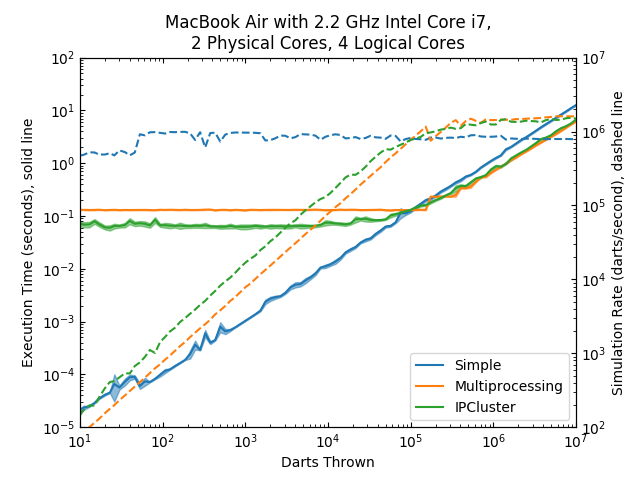

In [80]:
# Convert these lists to np arrays to make them easier to work with
exe_times_ipc_array = np.array(exe_times_ipc)
exe_errors_ipc_array = np.array(exe_errors_ipc)

fig, ax1 = plt.subplots()

# Change the background opacity, which defaults to transparent.
fig.patch.set_alpha(1)

# Plot execution times.
ax1.loglog(x, exe_times, color="C0", label="Simple")
ax1.loglog(x_mp, exe_times_mp, color="C1", label="Multiprocessing")
ax1.loglog(x_ipc, exe_times_ipc, color="C2", label="IPCluster")

# Plot std's as highlighted regions.
ax1.fill_between(x, exe_times_array - exe_errors_array / 2, 
                 exe_times_array + exe_errors_array / 2,
                 alpha=0.5, edgecolor="C0", facecolor="C0")
ax1.fill_between(x_mp, exe_times_mp_array - exe_errors_mp_array / 2, 
                 exe_times_mp_array + exe_errors_mp_array / 2,
                 alpha=0.5, edgecolor="C1", facecolor="C1")
ax1.fill_between(x_ipc, exe_times_ipc_array - exe_errors_ipc_array / 2, 
                 exe_times_ipc_array + exe_errors_ipc_array / 2,
                 alpha=0.5, edgecolor="C2", facecolor="C2")

# Plot simulation rates.
ax2 = ax1.twinx()
ax2.loglog(x, sim_rates, linestyle="--")
ax2.loglog(x_mp, sim_rates_mp, linestyle="--")
ax2.loglog(x_ipc, sim_rates_ipc, linestyle="--")

# Set reasonable x/y limits.
plt.xlim(10, 10**7)
ax1.set_ylim(10**-5, 10**2)
ax2.set_ylim(10**2, 10**7)

# Set labels/title for plot
ax1.set_ylabel("Execution Time (seconds), solid line")
ax1.set_xlabel("Darts Thrown")
ax2.set_ylabel("Simulation Rate (darts/second), dashed line")
plt.title("MacBook Air with 2.2 GHz Intel Core i7,\n2 Physical Cores, "
          "4 Logical Cores")

# Show the legend in the location that mpl deems best.
ax1.legend(loc="lower right")

# Turn on plt ticks on the top of the plot and have them pointing in to plot.
ax1.tick_params(which="both", top="on", direction="in")
ax2.tick_params(which="both", direction="in")

# Save Plot
plt.savefig("analysis_plot_all.png")

plt.show()

# Analysis

For some reason the data doesn't match up exactly with the two example plots, which are remarkably similar despite having been run on two completely different machines.

Nonetheless, qualitatively the most important features of the plots match the examples. In particular, by looking at the large n (Darts Thrown) region we see that the multiprocessing and IPcluster implementations outperform the simple implementation by a factor of ~2. Consistent with this, the simulation rates for the two parallel implementations are about a factor of 2 faster in this region than the simple algorithm.

Where my data differs significantly from the examples is in the small n region (below 10^5 darts thrown). Here the example data does better than mine by one or two orders of magnitude. In addition, the point where my parallel implementations surpass the serial implementation in performance is again about one or two orders of magnitude later than in the example data. I think that this might be because I had many other processes running in the background while performing these tests (lots of Chrome tabs, Adobe Acrobat, etc.), but I'm not sure. 

At any rate (and in conclusion), I definitely see a performance increase in the limit of large n by about a factor of 2 for the parallel implementations -- which matches the sample plots provided, but not the naive assumption one might have that using 4 cores as opposed to 1 would increase the performance by a factor of 4. It's possible that this is due to the fact that I only have 2 physical cores.